In [1]:
conda install -c conda-forge osmium-tool

Jupyter detected...
2 channel Terms of Service accepted
doneieving notices: - 
Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
doneecting package metadata (repodata.json): / 
doneing environment: / 


==> WARNING: A newer version of conda exists. <==
    current version: 25.7.0
    latest version: 25.11.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - osmium-tool


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    boost-cpp-1.84.0           |       hca5e981_3          16 KB  conda-forge
    ca-certificates-2025.11.12 |       hbd8a1cb_0         149 KB  conda-forge
    certifi-2025.11.12         |     pyhd8ed1ab_0         153 KB  conda-forge
    icu-73.2                   |       hc8870d7_0        11.4 MB  conda-forge
    libboost-1.84.0            |       

In [2]:
import os, shutil, subprocess, sys
import rasterio
from rasterio.warp import transform_bounds

PROJECT_DIR  = "/Users/wangbobo/Desktop/2nd_Assignment-20251222"
DATASETS_DIR = os.path.join(PROJECT_DIR, "datasets")
TERRAIN_PATH = os.path.join(DATASETS_DIR, "terrain.tif")
PBF_PATH     = os.path.join(PROJECT_DIR, "great-britain-251231.osm.pbf")

OUT_DIR = os.path.join(DATASETS_DIR, "outputs_residential_osm_fast2")
os.makedirs(OUT_DIR, exist_ok=True)

# --- tools ---
ogr2ogr = shutil.which("ogr2ogr")
osmium  = shutil.which("osmium")
if ogr2ogr is None:
    raise RuntimeError("找不到 ogr2ogr（GDAL）。先装 QGIS 或 gdal。")
if osmium is None:
    raise RuntimeError(
        "找不到 osmium-tool。\n"
        "请在终端执行：conda install -c conda-forge osmium-tool\n"
        "装完重启 Jupyter kernel。"
    )


with rasterio.open(TERRAIN_PATH) as src:
    b = src.bounds
    crs = src.crs
    lonmin, latmin, lonmax, latmax = transform_bounds(
        crs, "EPSG:4326", b.left, b.bottom, b.right, b.top, densify_pts=21
    )

print("✅ DEM bbox (WGS84):", (lonmin, latmin, lonmax, latmax))
print("✅ osmium:", osmium)
print("✅ ogr2ogr:", ogr2ogr)


clip_pbf   = os.path.join(OUT_DIR, "gb_clip_dem_bbox.osm.pbf")
filt_pbf   = os.path.join(OUT_DIR, "gb_clip_residential.osm.pbf")


def run_stream(cmd):
    print("▶", " ".join(cmd))
    p = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, bufsize=1)
    for line in p.stdout:
        print(line, end="")
    rc = p.wait()
    if rc != 0:
        raise RuntimeError(f"Command failed ({rc}): {' '.join(cmd)}")


run_stream([
    osmium, "extract",
    "-b", f"{lonmin},{latmin},{lonmax},{latmax}",
    "-o", clip_pbf,
    "--overwrite",
    PBF_PATH
])


run_stream([
    osmium, "tags-filter",
    "-R",
    "-o", filt_pbf,
    "--overwrite",
    clip_pbf,
    "nwr/landuse=residential",
    "nwr/building=residential",
    "nwr/building=apartments",
    "nwr/building=house",
    "nwr/building=detached",
    "nwr/building=terrace",
    "nwr/building=semidetached_house"
])

print("\n✅ filtered pbf:", filt_pbf)


✅ DEM bbox (WGS84): (-9.35049802566716, 49.766806809681874, 2.788160947205139, 60.95243222198082)
✅ osmium: /opt/anaconda3/bin/osmium
✅ ogr2ogr: /opt/anaconda3/bin/ogr2ogr
▶ /opt/anaconda3/bin/osmium extract -b -9.35049802566716,49.766806809681874,2.788160947205139,60.95243222198082 -o /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs_residential_osm_fast2/gb_clip_dem_bbox.osm.pbf --overwrite /Users/wangbobo/Desktop/2nd_Assignment-20251222/great-britain-251231.osm.pbf
▶ /opt/anaconda3/bin/osmium tags-filter -R -o /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs_residential_osm_fast2/gb_clip_residential.osm.pbf --overwrite /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs_residential_osm_fast2/gb_clip_dem_bbox.osm.pbf nwr/landuse=residential nwr/building=residential nwr/building=apartments nwr/building=house nwr/building=detached nwr/building=terrace nwr/building=semidetached_house

✅ filtered pbf: /Users/wangbobo/Desktop/2nd_Assignment-2025

In [4]:
import os, shutil, subprocess

OUT_DIR   = "/Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs_residential_osm_fast2"
filt_pbf  = os.path.join(OUT_DIR, "gb_clip_residential.osm.pbf")

GPKG_PATH   = os.path.join(OUT_DIR, "osm_residential.gpkg")
LAYER_NAME  = "residential_poly"

ogr2ogr = shutil.which("ogr2ogr")
ogrinfo = shutil.which("ogrinfo")
if ogr2ogr is None or ogrinfo is None:
    raise RuntimeError("找不到 GDAL 的 ogr2ogr/ogrinfo。")


def run_stream(cmd):
    print("▶", " ".join(cmd))
    p = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, bufsize=1)
    for line in p.stdout:
        print(line, end="")
    rc = p.wait()
    if rc != 0:
        raise RuntimeError(f"Command failed ({rc}): {' '.join(cmd)}")

print("=== Layers in filt_pbf ===")
print(subprocess.check_output([ogrinfo, "-ro", "-so", filt_pbf], text=True, stderr=subprocess.STDOUT))


if os.path.exists(GPKG_PATH):
    os.remove(GPKG_PATH)


run_stream([
    ogr2ogr, "-progress",
    "-f", "GPKG", GPKG_PATH, filt_pbf,
    "-nln", LAYER_NAME,
    "multipolygons",
    "-skipfailures"
])


run_stream([
    ogr2ogr, "-progress",
    "-append",
    "-f", "GPKG", GPKG_PATH, filt_pbf,
    "-nln", LAYER_NAME,
    "other_relations",
    "-skipfailures"
])

print("✅ DONE. GPKG =", GPKG_PATH)


=== Layers in filt_pbf ===
INFO: Open of `/Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs_residential_osm_fast2/gb_clip_residential.osm.pbf'
      using driver `OSM' successful.
1: points (Point)
2: lines (Line String)
3: multilinestrings (Multi Line String)
4: multipolygons (Multi Polygon)
5: other_relations (Geometry Collection)

▶ /opt/anaconda3/bin/ogr2ogr -progress -f GPKG /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs_residential_osm_fast2/osm_residential.gpkg /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs_residential_osm_fast2/gb_clip_residential.osm.pbf -nln residential_poly multipolygons -skipfailures
0...10...20...30...40...50...60...70...80...90...100 - done.
▶ /opt/anaconda3/bin/ogr2ogr -progress -append -f GPKG /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs_residential_osm_fast2/osm_residential.gpkg /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs_residential_osm_fast2/gb_clip_residentia

In [5]:
import os
import numpy as np
import rasterio
from rasterio.features import rasterize
import geopandas as gpd
import matplotlib.pyplot as plt


PROJECT_DIR  = "/Users/wangbobo/Desktop/2nd_Assignment-20251222"
DATASETS_DIR = os.path.join(PROJECT_DIR, "datasets")

TERRAIN_PATH = os.path.join(DATASETS_DIR, "terrain.tif")

OUT_DIR      = os.path.join(DATASETS_DIR, "outputs_residential_osm_fast2")
GPKG_PATH    = os.path.join(OUT_DIR, "osm_residential.gpkg")
LAYER_NAME   = "residential_poly"

os.makedirs(OUT_DIR, exist_ok=True)


OUT_EXCL_TIF = os.path.join(OUT_DIR, "residential_excluded_mask.tif")      # 0/1
OUT_DIST_TIF = os.path.join(OUT_DIR, "residential_distance_m.tif")         # meters
OUT_SUIT_TIF = os.path.join(OUT_DIR, "residential_suitability_0_1.tif")     # 0-1 float
OUT_PNG      = os.path.join(OUT_DIR, "residential_triplet_osm.png")


with rasterio.open(TERRAIN_PATH) as dem:
    dem_arr = dem.read(1, masked=True)           # masked array
    dem_meta = dem.meta.copy()
    transform = dem.transform
    crs = dem.crs
    height, width = dem.height, dem.width
    
  
    land_mask = ~dem_arr.mask


px = abs(transform.a)
py = abs(transform.e)
cell = float((px + py) / 2.0)

print("✅ DEM shape:", (height, width))
print("✅ pixel size (m):", cell)
print("✅ land pixels:", int(land_mask.sum()))


print("▶ reading residential polygons ...")
gdf = gpd.read_file(GPKG_PATH, layer=LAYER_NAME)

if gdf.empty:
    raise RuntimeError("residential_poly 图层是空的（没有要素）。")


gdf = gdf[gdf.geometry.notnull()]
gdf = gdf[gdf.is_valid]


if gdf.crs is None:
    raise RuntimeError("GPKG 没有 CRS 信息（gdf.crs=None）。需要你确认导出时 CRS。")
if gdf.crs != crs:
    gdf = gdf.to_crs(crs)

print("✅ features:", len(gdf))


shapes = ((geom, 1) for geom in gdf.geometry)

excluded = rasterize(
    shapes=shapes,
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype="uint8",
    all_touched=False
)

excluded = np.where(land_mask, excluded, 0).astype("uint8")


mask_meta = dem_meta.copy()
mask_meta.update({"dtype":"uint8", "count":1, "nodata":0, "compress":"LZW"})
with rasterio.open(OUT_EXCL_TIF, "w", **mask_meta) as dst:
    dst.write(excluded, 1)

excluded_pct = 100.0 * excluded[land_mask].mean()
print(f"✅ Excluded % of LAND pixels (residential) = {excluded_pct:.2f}%")
print("✅ saved:", OUT_EXCL_TIF)


try:
    from scipy.ndimage import distance_transform_edt
    
   
    inv = np.ones((height, width), dtype="uint8")
    inv[excluded == 1] = 0  
    
    dist_pix = distance_transform_edt(inv)       # 单位：像元
    dist_m = dist_pix * cell                     # 单位：米
    
except Exception as e:
    raise RuntimeError(
        "你的环境没有 scipy 或 distance_transform_edt 不能用。\n"
        "建议：conda install -c conda-forge scipy\n"
        f"原始错误: {e}"
    )


dist_m = dist_m.astype("float32")
dist_m[~land_mask] = np.nan

dist_meta = dem_meta.copy()
dist_meta.update({"dtype":"float32", "count":1, "nodata":np.nan, "compress":"LZW"})
with rasterio.open(OUT_DIST_TIF, "w", **dist_meta) as dst:
    dst.write(dist_m, 1)

print("✅ saved:", OUT_DIST_TIF)


D0 = 1000.0
D1 = 5000.0

suit = (dist_m - D0) / (D1 - D0)
suit = np.clip(suit, 0.0, 1.0).astype("float32")
suit[~land_mask] = np.nan

suit_meta = dem_meta.copy()
suit_meta.update({"dtype":"float32", "count":1, "nodata":np.nan, "compress":"LZW"})
with rasterio.open(OUT_SUIT_TIF, "w", **suit_meta) as dst:
    dst.write(suit, 1)

print("✅ saved:", OUT_SUIT_TIF)


fig, axes = plt.subplots(1, 3, figsize=(18, 7))

ax1 = axes[0]
im1 = ax1.imshow(dem_arr, interpolation="nearest")
ax1.set_title("Elevation (terrain.tif)")
ax1.axis("off")
cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.02)
cbar1.set_label("Elevation (m)")


ax2 = axes[1]
im2 = ax2.imshow(dem_arr, interpolation="nearest")
ax2.set_title("Residential overlay (excluded areas)")
ax2.axis("off")
cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.02)
cbar2.set_label("Elevation (m)")


excluded_only = np.ma.masked_where(excluded == 0, excluded)
ax2.imshow(excluded_only, interpolation="nearest", alpha=0.7) 


ax3 = axes[2]
im3 = ax3.imshow(suit, vmin=0, vmax=1, interpolation="nearest")
ax3.set_title(f"Residential suitability (0–1)\nD0={int(D0)}m, D1={int(D1)}m (land-only)")
ax3.axis("off")
cbar3 = plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.02)
cbar3.set_label("Suitability (0–1)")

fig.suptitle(
    f"Constraint factor: Residential proximity (OSM filtered, land-only) | Excluded: {excluded_pct:.2f}% of land",
    y=0.98, fontsize=14
)
plt.tight_layout()

fig.savefig(OUT_PNG, dpi=200)
plt.show()

print("✅ Saved figure:", OUT_PNG)
print("✅ DONE. Output folder:", OUT_DIR)


✅ DEM shape: (492, 264)
✅ pixel size (m): 2500.0
✅ land pixels: 129888
▶ reading residential polygons ...


GEOSException: IllegalArgumentException: Invalid number of points in LinearRing found 2 - must be 0 or >= 4

✅ TERRAIN: /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/terrain.tif
✅ GPKG   : /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs_residential_osm_fast2/osm_residential.gpkg
▶ /opt/anaconda3/bin/ogr2ogr -f GPKG /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs_residential_osm_fast2/osm_residential_fixed.gpkg /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs_residential_osm_fast2/osm_residential.gpkg -nln residential_poly_fixed -nlt MULTIPOLYGON -makevalid -skipfailures
✅ fixed gpkg: /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs_residential_osm_fast2/osm_residential_fixed.gpkg
✅ DEM shape: (492, 264)
✅ pixel size (m): 2500.0
✅ residential polygons: 35
✅ Excluded % of LAND pixels (residential) = 0.01%
✅ saved: /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs_residential_osm_fast2/residential_excluded_mask.tif
✅ saved: /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs_residential_osm_f

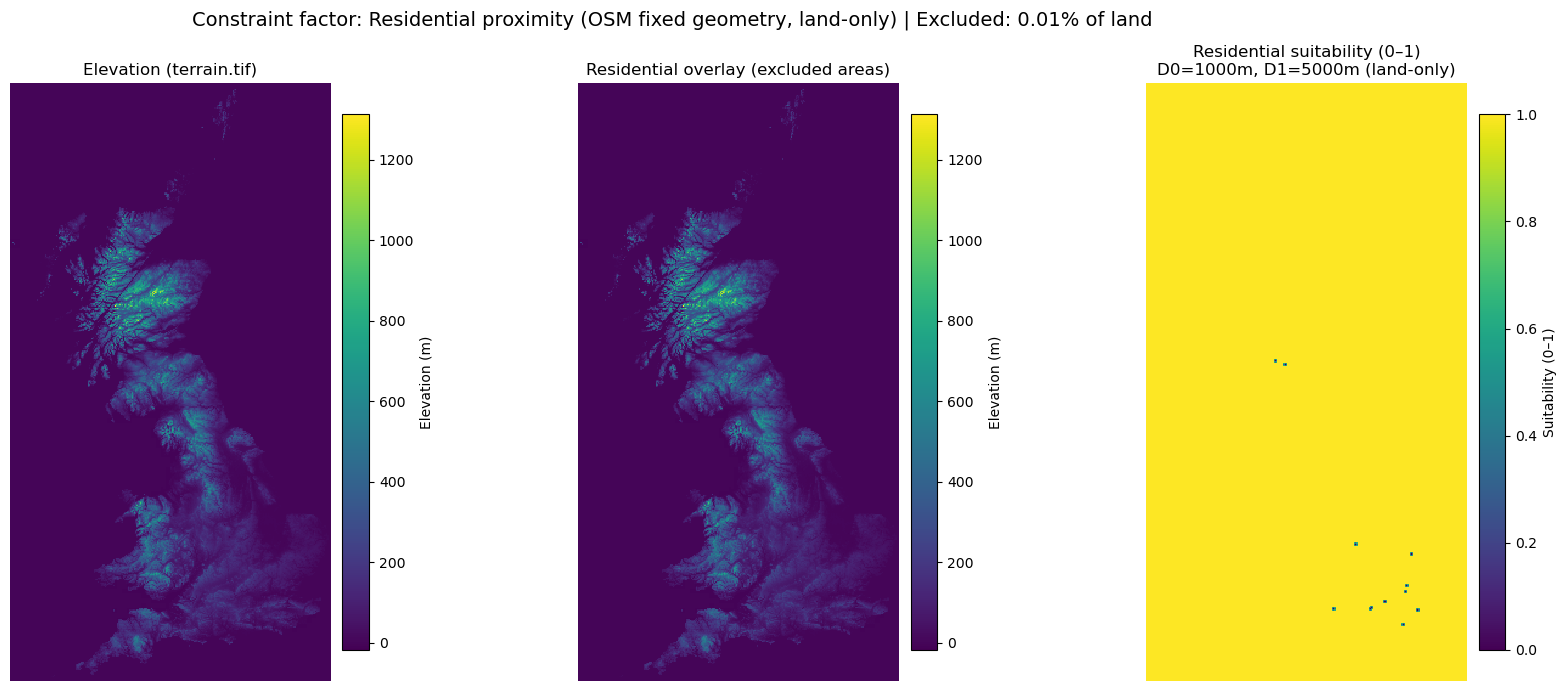

✅ Saved figure: /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs_residential_osm_fast2/residential_triplet_osm_FIXED.png
✅ DONE. Output folder: /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs_residential_osm_fast2


In [6]:
import os
import shutil
import subprocess
import numpy as np
import rasterio
from rasterio.features import rasterize
import geopandas as gpd
import matplotlib.pyplot as plt

PROJECT_DIR  = "/Users/wangbobo/Desktop/2nd_Assignment-20251222"
DATASETS_DIR = os.path.join(PROJECT_DIR, "datasets")

TERRAIN_PATH = os.path.join(DATASETS_DIR, "terrain.tif")

OUT_DIR      = os.path.join(DATASETS_DIR, "outputs_residential_osm_fast2")
GPKG_PATH    = os.path.join(OUT_DIR, "osm_residential.gpkg")
LAYER_NAME   = "residential_poly"


GPKG_FIXED   = os.path.join(OUT_DIR, "osm_residential_fixed.gpkg")
LAYER_FIXED  = "residential_poly_fixed"

OUT_EXCL_TIF = os.path.join(OUT_DIR, "residential_excluded_mask.tif")
OUT_DIST_TIF = os.path.join(OUT_DIR, "residential_distance_m.tif")
OUT_SUIT_TIF = os.path.join(OUT_DIR, "residential_suitability_0_1.tif")
OUT_PNG      = os.path.join(OUT_DIR, "residential_triplet_osm_FIXED.png")

os.makedirs(OUT_DIR, exist_ok=True)


if not os.path.exists(TERRAIN_PATH):
    raise FileNotFoundError(f"terrain.tif not found: {TERRAIN_PATH}")
if not os.path.exists(GPKG_PATH):
    raise FileNotFoundError(f"osm_residential.gpkg not found: {GPKG_PATH}")

print("✅ TERRAIN:", TERRAIN_PATH)
print("✅ GPKG   :", GPKG_PATH)


ogr2ogr = shutil.which("ogr2ogr")
if ogr2ogr is None:
    raise RuntimeError("找不到 ogr2ogr（GDAL）。你现在环境里应该有，因为你前面已经用过。")

def run(cmd):
    print("▶", " ".join(cmd))
    p = subprocess.run(cmd, text=True, capture_output=True)
    if p.returncode != 0:
        print(p.stdout)
        print(p.stderr)
        raise RuntimeError("❌ ogr2ogr 执行失败（看上面报错）")
    if p.stdout.strip():
        print(p.stdout)


if os.path.exists(GPKG_FIXED):
    os.remove(GPKG_FIXED)

run([
    ogr2ogr,
    "-f", "GPKG", GPKG_FIXED, GPKG_PATH,
    "-nln", LAYER_FIXED,
    "-nlt", "MULTIPOLYGON",
    "-makevalid",
    "-skipfailures"
])

print("✅ fixed gpkg:", GPKG_FIXED)

with rasterio.open(TERRAIN_PATH) as dem:
    dem_arr = dem.read(1, masked=True)
    dem_meta = dem.meta.copy()
    transform = dem.transform
    crs = dem.crs
    height, width = dem.height, dem.width
    
    land_mask = ~dem_arr.mask  # True=陆地
    
    px = abs(transform.a)
    py = abs(transform.e)
    cell = float((px + py) / 2.0)

print("✅ DEM shape:", (height, width))
print("✅ pixel size (m):", cell)


gdf = gpd.read_file(GPKG_FIXED, layer=LAYER_FIXED)

if gdf.empty:
    raise RuntimeError("❌ 修复后的图层是空的（没有要素），检查前一步过滤是否过严。")

gdf = gdf[gdf.geometry.notnull()]
gdf = gdf[gdf.is_valid]

if gdf.crs is None:
    raise RuntimeError("❌ 修复后的 GPKG 没有 CRS（gdf.crs=None），无法对齐 DEM。")

if gdf.crs != crs:
    gdf = gdf.to_crs(crs)

print("✅ residential polygons:", len(gdf))


shapes = ((geom, 1) for geom in gdf.geometry)

excluded = rasterize(
    shapes=shapes,
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype="uint8",
    all_touched=False
)


excluded = np.where(land_mask, excluded, 0).astype("uint8")

mask_meta = dem_meta.copy()
mask_meta.update({"dtype": "uint8", "count": 1, "nodata": 0, "compress": "LZW"})
with rasterio.open(OUT_EXCL_TIF, "w", **mask_meta) as dst:
    dst.write(excluded, 1)

excluded_pct = 100.0 * excluded[land_mask].mean()
print(f"✅ Excluded % of LAND pixels (residential) = {excluded_pct:.2f}%")
print("✅ saved:", OUT_EXCL_TIF)


try:
    from scipy.ndimage import distance_transform_edt
except Exception as e:
    raise RuntimeError(
        "❌ 你环境没有 scipy，无法算距离。\n"
        "请运行：conda install -c conda-forge scipy\n"
        f"原始错误: {e}"
    )

inv = np.ones((height, width), dtype="uint8")
inv[excluded == 1] = 0  # 居民区为 0，其它为 1

dist_pix = distance_transform_edt(inv)  # 到最近 0 的距离（像元单位）
dist_m = (dist_pix * cell).astype("float32")
dist_m[~land_mask] = np.nan

dist_meta = dem_meta.copy()
dist_meta.update({"dtype": "float32", "count": 1, "nodata": np.nan, "compress": "LZW"})
with rasterio.open(OUT_DIST_TIF, "w", **dist_meta) as dst:
    dst.write(dist_m, 1)

print("✅ saved:", OUT_DIST_TIF)

D0 = 1000.0
D1 = 5000.0

suit = (dist_m - D0) / (D1 - D0)
suit = np.clip(suit, 0.0, 1.0).astype("float32")
suit[~land_mask] = np.nan

suit_meta = dem_meta.copy()
suit_meta.update({"dtype": "float32", "count": 1, "nodata": np.nan, "compress": "LZW"})
with rasterio.open(OUT_SUIT_TIF, "w", **suit_meta) as dst:
    dst.write(suit, 1)

print("✅ saved:", OUT_SUIT_TIF)


fig, axes = plt.subplots(1, 3, figsize=(18, 7))

# 1) DEM
ax1 = axes[0]
im1 = ax1.imshow(dem_arr, interpolation="nearest")
ax1.set_title("Elevation (terrain.tif)")
ax1.axis("off")
cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.02)
cbar1.set_label("Elevation (m)")

# 2) Overlay：DEM + 紫色 excluded
ax2 = axes[1]
im2 = ax2.imshow(dem_arr, interpolation="nearest")
ax2.set_title("Residential overlay (excluded areas)")
ax2.axis("off")
cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.02)
cbar2.set_label("Elevation (m)")

excluded_only = np.ma.masked_where(excluded == 0, excluded)
ax2.imshow(excluded_only, interpolation="nearest", alpha=0.7)

# 3) Suitability 0-1（land-only）
ax3 = axes[2]
im3 = ax3.imshow(suit, vmin=0, vmax=1, interpolation="nearest")
ax3.set_title(f"Residential suitability (0–1)\nD0={int(D0)}m, D1={int(D1)}m (land-only)")
ax3.axis("off")
cbar3 = plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.02)
cbar3.set_label("Suitability (0–1)")

fig.suptitle(
    f"Constraint factor: Residential proximity (OSM fixed geometry, land-only) | Excluded: {excluded_pct:.2f}% of land",
    y=0.98, fontsize=14
)

plt.tight_layout()
fig.savefig(OUT_PNG, dpi=200)
plt.show()

print("✅ Saved figure:", OUT_PNG)
print("✅ DONE. Output folder:", OUT_DIR)


In [7]:
import os, shutil, subprocess
import numpy as np
import rasterio
from rasterio.features import rasterize
import geopandas as gpd
import matplotlib.pyplot as plt


PROJECT_DIR  = "/Users/wangbobo/Desktop/2nd_Assignment-20251222"
DATASETS_DIR = os.path.join(PROJECT_DIR, "datasets")

TERRAIN_PATH = os.path.join(DATASETS_DIR, "terrain.tif")
OUT_DIR      = os.path.join(DATASETS_DIR, "outputs_residential_osm_fast2")

GPKG_PATH    = os.path.join(OUT_DIR, "osm_residential.gpkg")


LAYER_NAME   = "residential_poly"

# 输出
OUT_PNG      = os.path.join(OUT_DIR, "residential_triplet_FIXED2.png")

BUFFER_M = 100   


D0 = 1000.0
D1 = 5000.0

os.makedirs(OUT_DIR, exist_ok=True)


with rasterio.open(TERRAIN_PATH) as dem:
    dem_arr = dem.read(1, masked=True)
    dem_meta = dem.meta.copy()
    transform = dem.transform
    crs = dem.crs
    height, width = dem.height, dem.width
    
    land_mask = ~dem_arr.mask  
    px = abs(transform.a)
    py = abs(transform.e)
    cell = float((px + py) / 2.0)
    
    dem_bounds = dem.bounds

print("✅ DEM CRS:", crs)
print("✅ DEM bounds:", dem_bounds)
print("✅ pixel(m):", cell)


gdf = gpd.read_file(GPKG_PATH, layer=LAYER_NAME)
gdf = gdf[gdf.geometry.notnull()]

print("✅ raw features:", len(gdf))
print("✅ layer CRS:", gdf.crs)
print("✅ layer bounds(raw):", gdf.total_bounds)

if gdf.crs is None:
    xmin, ymin, xmax, ymax = gdf.total_bounds
    if -180 <= xmin <= 180 and -90 <= ymin <= 90 and -180 <= xmax <= 180 and -90 <= ymax <= 90:
        gdf = gdf.set_crs("EPSG:4326")
        print("⚠️ CRS 缺失，已按 EPSG:4326 补上（因为 bounds 看起来是经纬度）")
    else:
        raise RuntimeError("❌ 层 CRS 缺失且 bounds 不像经纬度，无法自动判断。")


if gdf.crs != crs:
    gdf = gdf.to_crs(crs)

print("✅ layer bounds(on DEM CRS):", gdf.total_bounds)


if len(gdf) < 500:
    print("⚠️ 警告：居民区要素太少（<500），OSM 的 landuse=residential 面在很多地区（尤其苏格兰）确实不完整。")
    print("⚠️ 建议：改用 building 多边形（住宅类）或 OS MasterMap / OS Open UPRN / ONS Built-up Areas 等更完整数据。")


gdf_buf = gdf.copy()
gdf_buf["geometry"] = gdf_buf.geometry.buffer(BUFFER_M)

shapes = ((geom, 1) for geom in gdf_buf.geometry if geom is not None)

excluded = rasterize(
    shapes=shapes,
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype="uint8",
    all_touched=True  
)

excluded = np.where(land_mask, excluded, 0).astype("uint8")

excluded_pct = 100.0 * excluded[land_mask].mean()
print(f"✅ Excluded % of LAND pixels = {excluded_pct:.2f}%  (buffer={BUFFER_M}m)")


from scipy.ndimage import distance_transform_edt

inv = np.ones((height, width), dtype="uint8")
inv[excluded == 1] = 0

dist_pix = distance_transform_edt(inv)
dist_m = (dist_pix * cell).astype("float32")
dist_m[~land_mask] = np.nan

suit = (dist_m - D0) / (D1 - D0)
suit = np.clip(suit, 0.0, 1.0).astype("float32")
suit[~land_mask] = np.nan

fig, axes = plt.subplots(1, 3, figsize=(18, 7))

ax1 = axes[0]
im1 = ax1.imshow(dem_arr, interpolation="nearest")
ax1.set_title("Elevation (terrain.tif)")
ax1.axis("off")
c1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.02)
c1.set_label("Elevation (m)")

ax2 = axes[1]
im2 = ax2.imshow(dem_arr, interpolation="nearest")
ax2.set_title("Residential overlay (excluded areas)")
ax2.axis("off")
c2 = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.02)
c2.set_label("Elevation (m)")
ax2.imshow(np.ma.masked_where(excluded == 0, excluded), interpolation="nearest", alpha=0.75)

ax3 = axes[2]
im3 = ax3.imshow(suit, vmin=0, vmax=1, interpolation="nearest")
ax3.set_title(f"Residential suitability (0–1)\nD0={int(D0)}m, D1={int(D1)}m (land-only)")
ax3.axis("off")
c3 = plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.02)
c3.set_label("Suitability (0–1)")

fig.suptitle(
    f"Constraint: Residential proximity (buffered, land-only) | Excluded: {excluded_pct:.2f}% of land",
    y=0.98, fontsize=14
)

plt.tight_layout()
fig.savefig(OUT_PNG, dpi=200)
plt.show()

print("✅ Saved:", OUT_PNG)


✅ DEM CRS: EPSG:27700
✅ DEM bounds: BoundingBox(left=0.00012004771269857883, bottom=-0.0003991583362221718, right=660000.0001200477, top=1229999.9996008417)
✅ pixel(m): 2500.0


GEOSException: IllegalArgumentException: Invalid number of points in LinearRing found 2 - must be 0 or >= 4

In [8]:
import os, subprocess, shutil
import numpy as np
import rasterio
from rasterio.features import rasterize
import geopandas as gpd
import matplotlib.pyplot as plt


PROJECT_DIR  = "/Users/wangbobo/Desktop/2nd_Assignment-20251222"
DATASETS_DIR = os.path.join(PROJECT_DIR, "datasets")

TERRAIN_PATH = os.path.join(DATASETS_DIR, "terrain.tif")

OUT_DIR      = os.path.join(DATASETS_DIR, "outputs_residential_osm_fast2")
GPKG_PATH    = os.path.join(OUT_DIR, "osm_residential.gpkg")
LAYER_NAME   = "residential_poly" 

os.makedirs(OUT_DIR, exist_ok=True)

EXCLUDED_TIF = os.path.join(OUT_DIR, "residential_excluded_mask.tif")  # 0/1
DIST_TIF     = os.path.join(OUT_DIR, "residential_distance_m.tif")     # 米
SUIT_TIF     = os.path.join(OUT_DIR, "residential_suitability_0_1.tif")# 0-1
OUT_PNG      = os.path.join(OUT_DIR, "residential_triplet_FIXED_GDAL.png")

# 参数
BUFFER_M = 150      # 建议 50~200；越大居民影响区越连贯
D0 = 1000.0         # 1km内最不适合
D1 = 5000.0         # 5km外最适合


def find_gdal_proximity():
    
    for cand in [
        shutil.which("gdal_proximity.py"),
        shutil.which("gdal_proximity"),
        "/opt/anaconda3/bin/gdal_proximity.py",
        "/opt/anaconda3/bin/gdal_proximity",
    ]:
        if cand and os.path.exists(cand):
            return cand
    return None

GDAL_PROX = find_gdal_proximity()
if GDAL_PROX is None:
    raise RuntimeError(
        "找不到 gdal_proximity.py / gdal_proximity。\n"
        "你这个环境里 GDAL 可能没装好。\n"
        "建议：conda install -c conda-forge gdal"
    )
print("✅ gdal_proximity =", GDAL_PROX)


with rasterio.open(TERRAIN_PATH) as dem:
    dem_arr = dem.read(1, masked=True)
    meta = dem.meta.copy()
    transform = dem.transform
    crs = dem.crs
    height, width = dem.height, dem.width
    land_mask = ~dem_arr.mask  # True=陆地
    dem_bounds = dem.bounds

print("✅ DEM CRS:", crs)
print("✅ DEM bounds:", dem_bounds)
print("✅ DEM shape:", (height, width))


if not os.path.exists(GPKG_PATH):
    raise FileNotFoundError(f"GPKG not found: {GPKG_PATH}")

gdf = gpd.read_file(GPKG_PATH, layer=LAYER_NAME)
gdf = gdf[gdf.geometry.notnull()].copy()

print("✅ raw features:", len(gdf))
print("✅ layer CRS:", gdf.crs)
print("✅ layer bounds(raw):", gdf.total_bounds)

if gdf.crs is None:
    xmin, ymin, xmax, ymax = gdf.total_bounds
    if -180 <= xmin <= 180 and -90 <= ymin <= 90:
        gdf = gdf.set_crs("EPSG:4326")
        print("⚠️ layer CRS 缺失，按 EPSG:4326 补上（因为 bounds 像经纬度）")
    else:
        raise RuntimeError("layer CRS 缺失且 bounds 不像经纬度，无法自动判断。")


if gdf.crs != crs:
    gdf = gdf.to_crs(crs)

print("✅ layer bounds(on DEM CRS):", gdf.total_bounds)


gdf_buf = gdf.copy()
gdf_buf["geometry"] = gdf_buf.geometry.buffer(BUFFER_M)


shapes = ((geom, 1) for geom in gdf_buf.geometry if geom is not None and not geom.is_empty)

excluded = rasterize(
    shapes=shapes,
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype="uint8",
    all_touched=True
)
excluded = np.where(land_mask, excluded, 0).astype("uint8")

excluded_pct = 100.0 * excluded[land_mask].mean()
print(f"✅ Excluded % of LAND pixels = {excluded_pct:.2f}% (buffer={BUFFER_M}m)")


if excluded_pct < 0.2:
    print("⚠️ 排除比例非常低，说明你的 residential 图层在 DEM 范围里很稀少 -> 会导致第三张图几乎全黄。")
    print("⚠️ 建议：不要只用 landuse=residential；改用 building 多边形（或更权威 OS/ONS 数据）。")


meta_ex = meta.copy()
meta_ex.update(dtype="uint8", count=1, nodata=0, compress="lzw")
with rasterio.open(EXCLUDED_TIF, "w", **meta_ex) as dst:
    dst.write(excluded, 1)
print("✅ Saved mask:", EXCLUDED_TIF)


DIST_PIX_TIF = os.path.join(OUT_DIR, "residential_distance_pix.tif")


cmd = [
    GDAL_PROX,
    EXCLUDED_TIF,
    DIST_PIX_TIF,
    "-values", "1",
    "-distunits", "PIXEL"
]
print("▶ Running:", " ".join(cmd))
subprocess.check_call(cmd)


with rasterio.open(DIST_PIX_TIF) as dp:
    dist_pix = dp.read(1).astype("float32")
    dp_meta = dp.meta.copy()


px = abs(transform.a)
py = abs(transform.e)
cell = float((px + py) / 2.0)

dist_m = dist_pix * cell
dist_m[~land_mask] = np.nan

meta_dm = meta.copy()
meta_dm.update(dtype="float32", count=1, nodata=np.nan, compress="lzw")
with rasterio.open(DIST_TIF, "w", **meta_dm) as dst:
    dst.write(dist_m.astype("float32"), 1)
print("✅ Saved distance(m):", DIST_TIF)


suit = (dist_m - D0) / (D1 - D0)
suit = np.clip(suit, 0.0, 1.0).astype("float32")
suit[~land_mask] = np.nan

meta_s = meta.copy()
meta_s.update(dtype="float32", count=1, nodata=np.nan, compress="lzw")
with rasterio.open(SUIT_TIF, "w", **meta_s) as dst:
    dst.write(suit, 1)
print("✅ Saved suitability:", SUIT_TIF)


fig, axes = plt.subplots(1, 3, figsize=(18, 7))

ax1 = axes[0]
im1 = ax1.imshow(dem_arr, interpolation="nearest")
ax1.set_title("Elevation (terrain.tif)")
ax1.axis("off")
c1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.02)
c1.set_label("Elevation (m)")

ax2 = axes[1]
im2 = ax2.imshow(dem_arr, interpolation="nearest")
ax2.set_title("Residential overlay (excluded areas)")
ax2.axis("off")
c2 = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.02)
c2.set_label("Elevation (m)")
ax2.imshow(np.ma.masked_where(excluded == 0, excluded), interpolation="nearest", alpha=0.75)

ax3 = axes[2]
im3 = ax3.imshow(suit, vmin=0, vmax=1, interpolation="nearest")
ax3.set_title(f"Residential suitability (0–1)\nD0={int(D0)}m, D1={int(D1)}m (land-only)")
ax3.axis("off")
c3 = plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.02)
c3.set_label("Suitability (0–1)")

fig.suptitle(
    f"Constraint: Residential proximity (GDAL proximity, buffered) | Excluded: {excluded_pct:.2f}% of land",
    y=0.98, fontsize=14
)

plt.tight_layout()
fig.savefig(OUT_PNG, dpi=200)
plt.show()
print("✅ Saved figure:", OUT_PNG)


RuntimeError: 找不到 gdal_proximity.py / gdal_proximity。
你这个环境里 GDAL 可能没装好。
建议：conda install -c conda-forge gdal

In [9]:
import numpy as np
import rasterio
from rasterio.enums import Resampling
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
import os


BASE = "/Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets"

DEM_PATH = os.path.join(BASE, "terrain.tif")
LCM_PATH = os.path.join(BASE, "landcover.tif")   # ← 你的 land cover tif
OUT_DIR = os.path.join(BASE, "outputs_residential_lcm")
os.makedirs(OUT_DIR, exist_ok=True)


D0 = 1000   # <1 km 完全不适合
D1 = 5000   # >5 km 完全适合


BUILTUP_CODES = [1, 2, 3] 


with rasterio.open(DEM_PATH) as dem:
    dem_arr = dem.read(1)
    dem_meta = dem.meta.copy()
    dem_transform = dem.transform
    dem_res = dem.res[0]

with rasterio.open(LCM_PATH) as lc:
    lc_arr = lc.read(
        1,
        out_shape=dem_arr.shape,
        resampling=Resampling.nearest
    )


builtup = np.isin(lc_arr, BUILTUP_CODES).astype(np.uint8)


distance = distance_transform_edt(1 - builtup) * dem_res


suitability = np.zeros_like(distance, dtype="float32")

suitability[distance >= D1] = 1.0
mid = (distance > D0) & (distance < D1)
suitability[mid] = (distance[mid] - D0) / (D1 - D0)


suitability[builtup == 1] = 0.0

out_tif = os.path.join(OUT_DIR, "residential_suitability_0_1.tif")
dem_meta.update(dtype="float32", count=1)

with rasterio.open(out_tif, "w", **dem_meta) as dst:
    dst.write(suitability, 1)


fig, axs = plt.subplots(1, 3, figsize=(14, 6))

axs[0].imshow(dem_arr, cmap="terrain")
axs[0].set_title("Elevation (DEM)")

axs[1].imshow(builtup, cmap="gray")
axs[1].set_title("Residential / Built-up")

im = axs[2].imshow(suitability, cmap="viridis", vmin=0, vmax=1)
axs[2].set_title("Residential suitability (0–1)")
plt.colorbar(im, ax=axs[2], fraction=0.046)

for ax in axs:
    ax.axis("off")

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "residential_triplet_LCM.png"), dpi=200)
plt.show()

print("✅ DONE:", OUT_DIR)


RasterioIOError: /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/landcover.tif: No such file or directory

✅ LCM_TIF = /Users/wangbobo/Desktop/uk land cover/data/0e3ab6f8-4a20-4a60-a804-e144fb0bde39/gblcm2024_25m.tif
✅ TERRAIN_PATH = /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/terrain.tif
⚠️ 没找到 QML。将打印 raster 的 unique 值供你确认 built-up code。

=== Land cover values (sampled top 30 by frequency) ===
[(0, 256), (4, 29), (3, 20), (1, 8), (20, 7), (10, 6), (21, 6), (7, 4), (2, 3), (9, 3), (11, 3), (13, 3), (18, 1), (19, 1)]

✅ Using BUILTUP_CODES = [1, 2, 3]
   如果第三张图全黄/全紫，大概率是 BUILTUP_CODES 不对：请根据上面输出把它改成真正的 Urban/Built-up 编码。


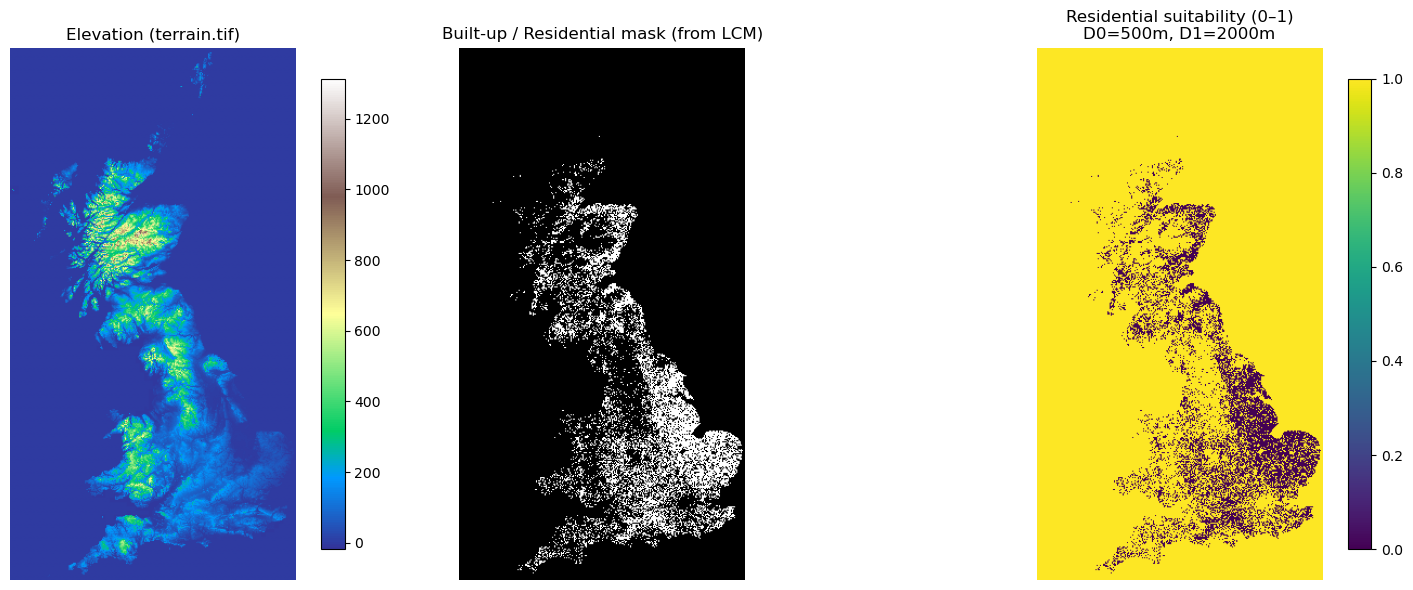


✅ Saved raster: /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs_residential_lcm/residential_suitability_0_1.tif
✅ Saved figure: /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs_residential_lcm/residential_triplet_LCM.png
✅ Built-up (excluded) share of valid area: 10.10%
✅ DONE: /Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets/outputs_residential_lcm
DEM CRS: EPSG:27700
DEM res: 2500.0
dist_px median: 19.6468827043885
dist_m median: 49117.20676097125


In [18]:


import os, glob, re
import numpy as np
import rasterio
from rasterio.enums import Resampling
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt


LCM_DIR = r"/Users/wangbobo/Desktop/uk land cover/data/0e3ab6f8-4a20-4a60-a804-e144fb0bde39"
TERRAIN_DIR = r"/Users/wangbobo/Desktop/2nd_Assignment-20251222/datasets"
TERRAIN_PATH = os.path.join(TERRAIN_DIR, "terrain.tif")


QML_CANDIDATES = [
    os.path.join(LCM_DIR, "lcm_raster.qml"),
    os.path.join(LCM_DIR, "lcm_raster_cb_friendly.qml"),
]

OUT_DIR = os.path.join(TERRAIN_DIR, "outputs_residential_lcm")
os.makedirs(OUT_DIR, exist_ok=True)


tif_candidates = []
tif_candidates += glob.glob(os.path.join(LCM_DIR, "*.tif"))
tif_candidates += glob.glob(os.path.join(LCM_DIR, "*.tiff"))
tif_candidates += glob.glob(os.path.join(LCM_DIR, "**", "*.tif"), recursive=True)
tif_candidates += glob.glob(os.path.join(LCM_DIR, "**", "*.tiff"), recursive=True)

tif_candidates = list({p for p in tif_candidates if os.path.isfile(p)})

if not tif_candidates:
    raise FileNotFoundError(f"在 {LCM_DIR} 里没找到任何 .tif/.tiff，请确认目录是否正确。")


LCM_TIF = max(tif_candidates, key=lambda p: os.path.getsize(p))
print("✅ LCM_TIF =", LCM_TIF)

if not os.path.exists(TERRAIN_PATH):
    raise FileNotFoundError(f"terrain.tif not found: {TERRAIN_PATH}")
print("✅ TERRAIN_PATH =", TERRAIN_PATH)


def find_qml_path():
    for p in QML_CANDIDATES:
        if os.path.exists(p):
            return p
    
    c = glob.glob(os.path.join(LCM_DIR, "**", "*.qml"), recursive=True)
    return c[0] if c else None

def parse_qml_palette(qml_path):
    """
    返回:
      palette: list of (value:int, label:str)
    """
    with open(qml_path, "r", encoding="utf-8", errors="ignore") as f:
        txt = f.read()

   
    pattern = r'paletteEntry[^>]*\bvalue="([^"]+)"[^>]*\blabel="([^"]*)"'
    matches = re.findall(pattern, txt)
    palette = []
    for v, lab in matches:
        try:
            vi = int(float(v))
        except:
            continue
        palette.append((vi, lab))
    return palette

QML_PATH = find_qml_path()
BUILTUP_CODES = None
palette = []

if QML_PATH:
    print("✅ Found QML =", QML_PATH)
    palette = parse_qml_palette(QML_PATH)

   
    keywords = [
        "urban", "built", "built-up", "builtup", "settlement", "residential",
        "suburban", "developed", "town", "city", "village"
    ]

    picked = []
    for v, lab in palette:
        lab_l = (lab or "").lower()
        if any(k in lab_l for k in keywords):
            picked.append(v)

    picked = sorted(list(set(picked)))
    if picked:
        BUILTUP_CODES = picked
        print("✅ Auto BUILTUP_CODES from QML =", BUILTUP_CODES)
    else:
        print("⚠️ QML 里没自动识别出 Urban/Built-up 类别。将打印 palette，供你手动确定。")
else:
    print("⚠️ 没找到 QML。将打印 raster 的 unique 值供你确认 built-up code。")

DEFAULT_BUILTUP_CODES = [1, 2, 3]  
if BUILTUP_CODES is None:
    BUILTUP_CODES = DEFAULT_BUILTUP_CODES


from rasterio.warp import reproject

with rasterio.open(LCM_TIF) as lc:
    lc_src = lc.read(1)

    lc_on_dem = np.full((dem_arr.shape[0], dem_arr.shape[1]), 0, dtype=lc_src.dtype)

    reproject(
        source=lc_src,
        destination=lc_on_dem,
        src_transform=lc.transform,
        src_crs=lc.crs,
        dst_transform=dem_transform,
        dst_crs=dem_crs,
        resampling=Resampling.nearest  


sample = lc_on_dem[::20, ::20]  
vals, counts = np.unique(sample, return_counts=True)
top = sorted(zip(vals.tolist(), counts.tolist()), key=lambda x: x[1], reverse=True)[:30]

print("\n=== Land cover values (sampled top 30 by frequency) ===")
print(top)

if palette:
    print("\n=== QML palette (first 60 entries) ===")
    for i, (v, lab) in enumerate(palette[:60]):
        print(f"{i:02d}: value={v}, label={lab}")

print("\n✅ Using BUILTUP_CODES =", BUILTUP_CODES)
print("   如果第三张图全黄/全紫，大概率是 BUILTUP_CODES 不对：请根据上面输出把它改成真正的 Urban/Built-up 编码。")


D0 = 500     # 500 m: strong residential constraint
D1 = 2000    # 2000 m: negligible residential constraint

builtup = np.isin(lc_on_dem, BUILTUP_CODES).astype(np.uint8)


dist_m = distance_transform_edt(1 - builtup) * float(dem_res)


t = (dist_m - D0) / (D1 - D0)
t = np.clip(t, 0.0, 1.0)

suit = (t * t * (3 - 2 * t)).astype(np.float32)


suit[builtup == 1] = 0.0


if np.ma.isMaskedArray(dem_arr) and dem_arr.mask is not np.False_:
    suit = np.where(dem_arr.mask, np.nan, suit)


out_tif = os.path.join(OUT_DIR, "residential_suitability_0_1.tif")
meta = dem_meta.copy()
meta.update(dtype="float32", count=1, nodata=None)

with rasterio.open(out_tif, "w", **meta) as dst:
    dst.write(np.nan_to_num(suit, nan=-9999).astype("float32"), 1)


fig, axs = plt.subplots(1, 3, figsize=(16, 6))

im0 = axs[0].imshow(dem_arr, cmap="terrain")
axs[0].set_title("Elevation (terrain.tif)")
plt.colorbar(im0, ax=axs[0], fraction=0.046)

im1 = axs[1].imshow(np.where(np.isnan(suit), np.nan, builtup), cmap="gray")
axs[1].set_title("Built-up / Residential mask (from LCM)")

im2 = axs[2].imshow(suit, cmap="viridis", vmin=0, vmax=1)
axs[2].set_title(f"Residential suitability (0–1)\nD0={D0}m, D1={D1}m")
plt.colorbar(im2, ax=axs[2], fraction=0.046)

for ax in axs:
    ax.axis("off")

plt.tight_layout()
out_png = os.path.join(OUT_DIR, "residential_triplet_LCM.png")
plt.savefig(out_png, dpi=200)
plt.show()


valid = ~np.isnan(suit)
excluded_pct = (builtup[valid].sum() / valid.sum()) * 100 if valid.any() else np.nan
print(f"\n✅ Saved raster: {out_tif}")
print(f"✅ Saved figure: {out_png}")
print(f"✅ Built-up (excluded) share of valid area: {excluded_pct:.2f}%")
print("✅ DONE:", OUT_DIR)

print("DEM CRS:", dem_crs)
print("DEM res:", dem_res)
dist_px = distance_transform_edt(1 - builtup)
print("dist_px median:", float(np.nanmedian(dist_px)))
print("dist_m median:", float(np.nanmedian(dist_m)))
